# Implementing the SIFT algorithm with OpenCV basic functions
Author: Huy Nguyen (40090345)
GitHub: https://github.com/giahuy22012000/ImplementingSIFT

In this project, we attempt reimplement the famous Scale Invariant Feature Tranform algorithm to better understand how it works under the hood. The challenge is to complete the task using only OpenCV basic functions including:
```
imRead, resize, GaussianBlur, Sobel
```

In the second part of this project, we use the implemented algorithm to solve a simple task - retrieve the original image file from a print of it.

In [80]:
# import libraries
import cv2 as cv
import matplotlib.pyplot as plt
import PIL
import math
import numpy as np
from collections import namedtuple

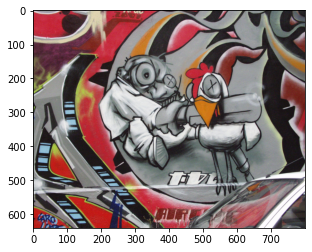

In [12]:
# read the image
image = cv.imread('data/graf1.png')
# cv2 by default read images as BGR
image_rgb = cv.cvtColor(image,cv.COLOR_BGR2RGB)
# display it
plt.imshow(image_rgb)

# Procedure
SIFT operator consists of 4 steps:
- Scale-space extrema detection
- Keypoint localization
- Orientation assignment
- Keypoint descriptor

In [43]:
# some constants
K = math.sqrt(2)
sigma = 1.6
kernel_size = 3
num_scales = 5
num_octave = 4


In [77]:
# basic functions


def gaussian_blur(image, sigma):
    # print(sigma)
    return cv.GaussianBlur(image, (kernel_size, kernel_size), sigma)


def downsample(image, factor=2):
    (rows, cols) = image.shape
    return cv.resize(image, (cols // 2, rows // 2))


In [37]:
def computeOctave(img, num_scales, sigma=1.6):
    # convolve image with different scale of gaussian
    out = []
    for i in range(num_scales):
        img_blur = gaussian_blur(img, sigma)
        out.append(img_blur)
        sigma *= K
    return out


def differentiateOctave(octave):
    # compute Difference of Gaussian
    out = []
    for i in range(len(octave)):
        if i != 0:
            img_DoG = octave[i] - octave[i - 1]
            out.append(img_DoG)
    return out


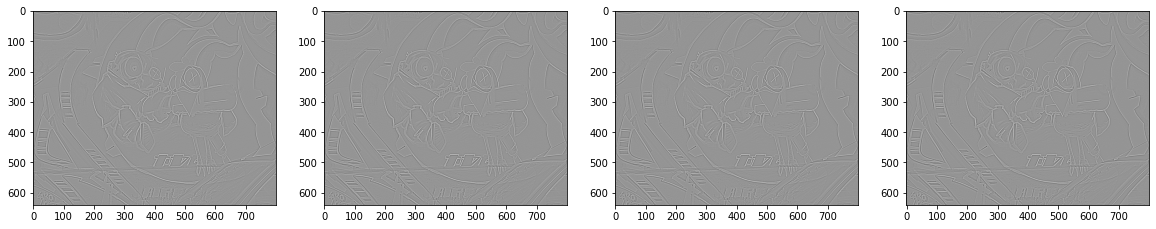

In [78]:
img_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
img_float = img_gray.astype(np.float32) / 256

octave = computeOctave(img_float, num_scales, sigma)
octave = differentiateOctave(octave)

# display DoG
plt.figure(figsize=(20, 10))
for i in range(len(octave)):
    plt.subplot(1, num_scales - 1, i + 1)
    plt.imshow(octave[i], cmap="Greys_r")


## 1. Detect extrema with DoG
In this first step, the input image is convoluted with a sequence of Gaussian kernel with increasing $\sigma$ values. The result images are then used to approximate Laplacian of Gaussian (LoG) by calculating Difference of Gaussian (DoG).

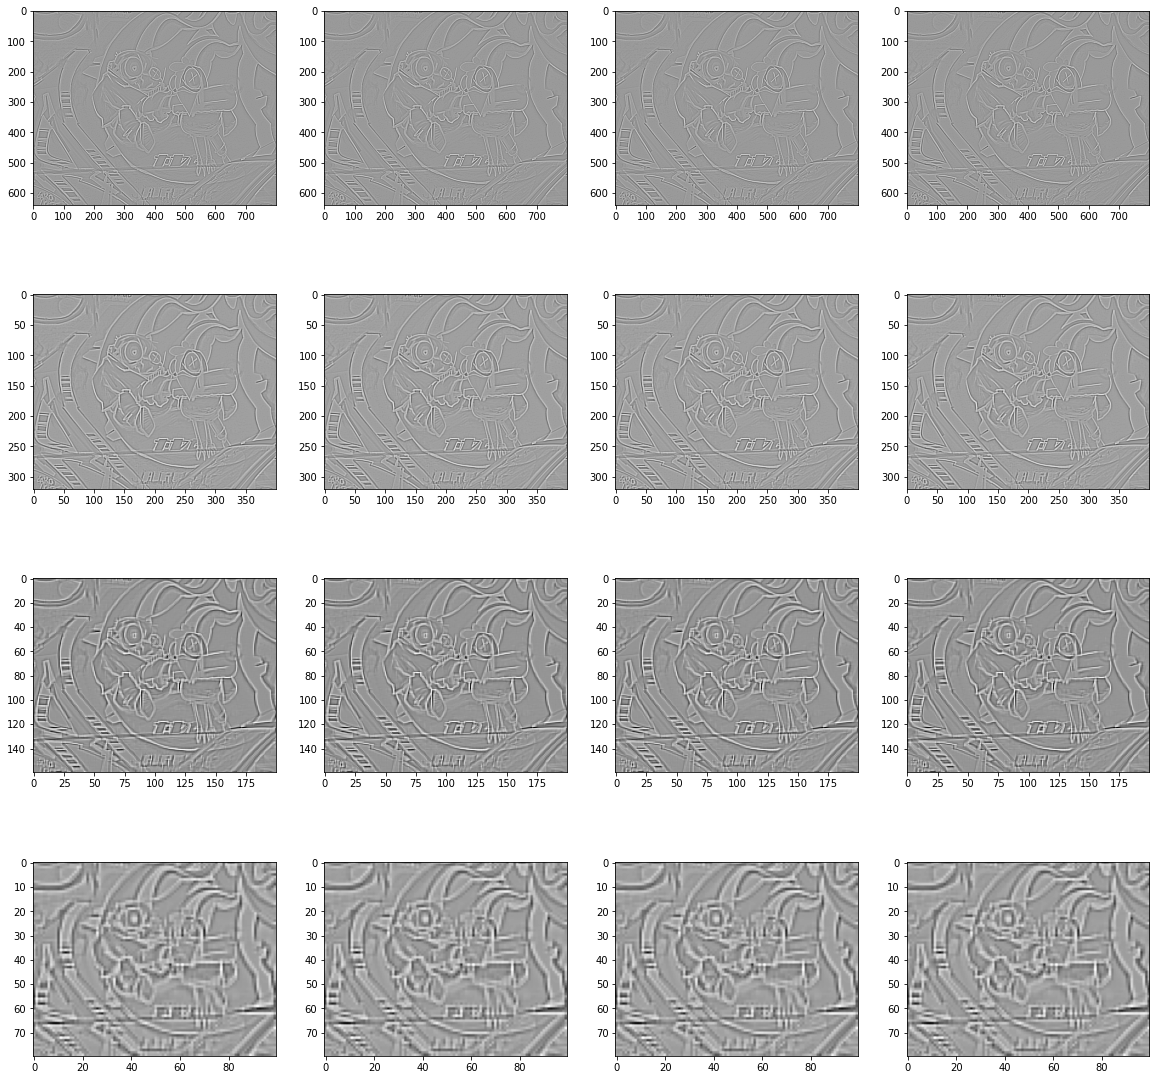

In [95]:

def detectExtrema(image):
    # compute Difference of Gaussian
    img_blur = gaussian_blur(image, sigma)
    octaves_DoG = []
    img_half = np.copy(img_blur)
    for i in range(num_octave):
        octave = computeOctave(img_half, num_scales, sigma * (i + 1))
        DoG = differentiateOctave(octave)
        octaves_DoG.append(DoG)
        img_half = downsample(img_half, 2)
    return octaves_DoG

# 
octaves_DoG = detectExtrema(img_float)
plt.figure(figsize=(20, 20))
for i in range(num_octave):
    for j in range(num_scales-1):
        plt.subplot(num_octave, num_scales - 1, i*(num_scales-1)+j+1)
        plt.imshow(octaves_DoG[i][j], cmap="Greys_r")



In [99]:
KeyPoint = namedtuple("KeyPoint", "x y")


def locateKeypoints(octaves_DoG):
    # locate extrema in scale-space 3x3x3 neighborhood
    print(len(octaves_DoG), len(octaves_DoG[0]))
    kps = []
    map = np.zeros_like(octaves_DoG[0][0])
    for i in range(num_octave):
        for j in range(1, num_scales - 2):
            print(i, j)
            DoG_prev = octaves_DoG[i][j - 1]
            DoG_next = octaves_DoG[i][j + 1]
            DoG = octaves_DoG[i][j]
            (nrows, ncols) = DoG.shape
            for y in range(1, nrows - 1):
                for x in range(1, ncols - 1):
                    # skip if this is already marked as a keypoint
                    if map[y, x] == 0:
                        # 26 neighbor values
                        neighbors = np.array(
                            [
                                DoG_prev[y - 1, x - 1],
                                DoG_prev[y - 1, x],
                                DoG_prev[y - 1, x + 1],
                                DoG_prev[y, x - 1],
                                DoG_prev[y, x],
                                DoG_prev[y, x + 1],
                                DoG_prev[y + 1, x - 1],
                                DoG_prev[y + 1, x],
                                DoG_prev[y + 1, x + 1],
                                DoG[y - 1, x - 1],
                                DoG[y - 1, x],
                                DoG[y - 1, x + 1],
                                DoG[y, x - 1],
                                DoG[y, x + 1],
                                DoG[y + 1, x - 1],
                                DoG[y + 1, x],
                                DoG[y + 1, x + 1],
                                DoG_next[y - 1, x - 1],
                                DoG_next[y - 1, x],
                                DoG_next[y - 1, x + 1],
                                DoG_next[y, x - 1],
                                DoG_next[y, x],
                                DoG_next[y, x + 1],
                                DoG_next[y + 1, x - 1],
                                DoG_next[y + 1, x],
                                DoG_next[y + 1, x + 1],
                            ]
                        )
                        max, min = np.max(neighbors), np.min(neighbors)
                        center = DoG[y, x]
                        if center == max or center == min:
                            map[y, x] = 1
                            kps.append(KeyPoint(x, y))
    print(np.count_nonzero(map), " keypoints")
    return map, kps


_, keypoints = locateKeypoints(octaves_DoG)


4 4
0 1
0 2
1 1
1 2
2 1
2 2
3 1
3 2
55  keypoints


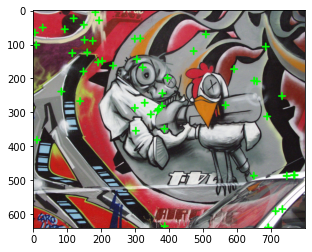

In [110]:
# draw detected keypoints
out = np.copy(image_rgb)

for kp in keypoints:
    cv.drawMarker(out,kp,color=(0,255,0),thickness=3)

plt.imshow(out)

# References:
1. D. G. Lowe, "Object recognition from local scale-invariant features," Proceedings of the Seventh IEEE International Conference on Computer Vision, 1999, pp. 1150-1157 vol.2, doi: 10.1109/ICCV.1999.790410.